In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats

import RatingsHelper as helper

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

import statsmodels.api as sm

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

So lately I have been getting very interested in probabilistic programming, specifically probabilistic graphical models, and wondering how I can apply them to college basketball ratings. I really like the idea of being to able to specify data problems graphically through probability models. So I started looking around the internet for similar examples of probabilistic graphical models (PGMs) applied to sports ratings, specifically implementations using Python interfaces like PyMC.

With some success, I found a really [nice write-up](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) on building a hierarchical Bayesian model to rate 20 soccer teams of the Premier league. The post is actually (mostly) a reconstruction of work performed in a similar paper [found here](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf). Anyway, they both use relatively simple, intuitive models to describe how points (goals in this case) are produced in a soccer game. I'll adapt it here to build a similar process for college basketball games.

## A scoring model for college basketball

There are many, many different approaches we could take to rating sports team's and, indeed, many have been applied in practice. Being able to better predict the outcomes of games that people care about and that people bet money on, it turns out, is quite appealing. One challenge that college basketball has, moreso than other sports, is that it is more difficult to measure a team's strength based off of traditional statistics that can be directly observed. We cannot simply look at wins/losses or points scored/allowed directly because college basketball team's play vastly different strengths of schedule. A team's observed output depends on the true skill of the team's that they have played. And the true skill of each team that they have played depends, in turn, on the true skill of the teams _those_ teams have played. So for college basketball ratings we can't just take some stats ("advanced" or otherwise) from the box score, shove them into a feature matrix, and run some scikit-learn algorithm (well, we could, but it wouldn't be very good). We need to think a bit deeper.

To solve our issues here, let's not think about how what we observe determines team ratings, but about how team ratings determine what we observe. This is a latent variable problem. When two team's play their ratings, which are hidden to us, combine to determine (approximately) what the outcome will be.

To formulate the process, we say that each team possesses an "offensive skill" rating and a "defensive skill" rating. When team A playes team B, the _expected_ points that team A will score is determined by team A's offensive skill and team B's defensive skill. But, as most college basketball fans (or sports fans in general) can tell you, if two team's play multiple games under exactly the same conditions, the actual score for team A will vary game-to-game. We in the data game like to call that randomness. So, a reasonable model for this randomness might be to assume that the true score is drawn from a normal distribution centered at the _expected_ points scored by team A. This model will be slightly more interpretable if we add an intercept, such that the offensive and defensive "skills" can be interpreted as points above or below average. 

For example, say the Bayes Ballers matchup versus Newton Netters where the two team's skills are:

In [3]:
pd.DataFrame([["Bayes Ballers", 5, 2], ["Newton Netters", -1, -3]], columns=["Team", "Off. Skill", "Def. Skill"])

,Team,Off. Skill,Def. Skill
0,Bayes Ballers,5,2
1,Newton Netters,-1,-3


We can interpret this as the Bayes Ballers scoring 5 points more than the league average and allowing 2 points more to opposing offenses than the league average. For the Newton Netters, they score 1 point less than the league average but allow 3 points less on defense. Assuming the league point average is 70 points, the expected points for each team are:

* Bayes Ballers expected points: 5 + -3 + 70 = 72
* Newton Netters expected points: -1 + 2 + 70 = 71

So, on average, we expect the Bayes Ballers to defeat the Newton Netters by a score of 72-71, a margin of one point. Still, that does not mean that the Newton Netters won't win from time to time. After all, the two team's seem pretty evenly matched and we know there is some randomness in the scores. Above, we said that the _expected_ points are fully determined by the team's ratings, but the true points, i.e. the points that we actually observe, are noisy or have some randomness. We chose to model that by saying that the true points are drawn from a constant mean Gaussian distribution centered at each team's expected point totals. 

We now have a model that allows us to explain the scores we see in college basketball games, and we know they are partly due to skill, and partly due to randomness. We can show this as a probabilistic graphical model via a DAG structure. 

Note: We'll also add a home court advantage parameter to our model, which will come in handy using real data.

TODO

Cool, we have now described a Bayesian network structure and all we should have left to do is to dump it into PyMC(3) and hit the inference button! 

**Not so fast.**

### An old friend
Let's restate what we have here: we have a model where a linear combination of explanatory variables (offensive/defensive skills, intercept, home advantage) influences the expected value of the response variable, which is a _random variable_ drawn from a normal distribution. Sound familiar? That's right, this is just the description of generalized linear model with a Gaussian family and identity link function! We got all excited to use our fancy probabilistic programming tools, equipped with our pretty graphical model, and all the while the dusty old linear model was sitting in the corner just waiting for us to notice.

In fact, it turns out that this type of ratings model was made prominent in the college basketball landscape by Kenneth Massey, who details such a model in [this mathematical paper from 1997](http://www.masseyratings.com/theory/massey97.pdf). Despite the wonky formatting, it's definitely worth a read for those looking for a gentle, mathematical introduction to sports ratings.

How shall we proceed then? We got all excited to use our PyMC inference button, only to realize that we had created a glorified linear regression that's been sitting in some pre-LaTeX era word document since 1997?! Despite our initial disappointment, it will be informative and even interesting to carry out this exercise using both the boring, old GLM and our PyMC inference button. To start, we'll work through an example with some made-up data using the [Statsmodels Python package](http://statsmodels.sourceforge.net/stable/index.html) for the GLM, and PyMC3 for the Bayesian network. We'll use some helper functions to synthesize data for a number of games between 5 teams.

## Validating models using simulated data

In [406]:
num_games, num_teams = 200, 5
off_skill, def_skill = helper.gen_ratings(num_teams)
print("Team true offensive skill ratings: %s" % off_skill)
print("Team true defensive skill ratings: %s" % def_skill)
# generate 200 random pairings between the 5 teams
matchups = helper.gen_matchups(num_games, num_teams)
intercept = 70  # mean score in units of points
home_advantage = 3  # home court advantage in units of points
true_std = 3  # constant standard deviation used in the actual score generation
games_df = helper.construct_games(off_skill, def_skill, matchups, intercept, home_advantage, true_std)
games_df.head()

Team true offensive skill ratings: [ 4.54597606 -1.92341316 -0.42714056  0.6969478  -2.89237014]
Team true defensive skill ratings: [ 0.08743228  0.0785644  -5.18293736  3.13420958  1.88273111]


,Home Team,Away Team,Home Off. Skill,Home Def. Skill,Away Off. Skill,Away Def. Skill,E[Home],E[Away],Home Score,Away Score
0,0,3,4.545976,0.087432,0.696948,3.134210,80.680186,67.784380,81.819932,66.175121
1,2,1,-0.427141,-5.182937,-1.923413,0.078564,72.651424,59.893649,75.664517,63.746799
2,3,4,0.696948,3.134210,-2.892370,1.882731,75.579679,67.241839,77.180043,68.435967
3,1,3,-1.923413,0.078564,0.696948,3.134210,74.210796,67.775512,72.444786,69.050445
4,1,2,-1.923413,0.078564,-0.427141,-5.182937,65.893649,66.651424,66.743539,62.323592


For each team we made up an offensive and defensive skill rating, and then randomly created pairings of the teams as games. In each game, we compute an expected home score E[Home] and an expected away score E[Away] and then use these values as the means of normal distributions from which the true scores (Home Score and Away Score) are drawn. We chose the standard deviation for this normal distribution to be a constant (i.e. homoscedastic) value of 3. To verify this, we can plot the errors between actual and expected scores, which should be distributed according to $\mathcal{N}(0, 3)$

Errors distributed with mean -0.01 and standard deviation 3.07


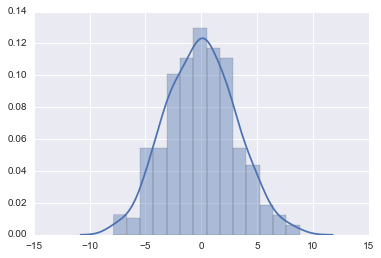

In [409]:
home_errors = games_df['Home Score'] - games_df['E[Home]']
away_errors = games_df['Away Score'] - games_df['E[Away]']
errors = np.append(home_errors.values, away_errors.values)
sns.distplot(errors)
print("Errors distributed with mean %1.2f and standard deviation %1.2f" % (np.mean(errors), np.std(errors)))

The data is pretty close to the normal distribution we'd expect, give or take some randomness. Now, to actually use this in a ratings model, we need to do some data wrangling. There are actually two sample points per row in the current dataframe, one for the home team and one for the away team. Let's "stack" the data which will double the number of rows, and drop some columns we don't need for the model.

In [389]:
feature_df = helper.construct_feature_df(games_df)
feature_df.head()

,Off. Team,Def. Team,Home,Score
0,0,3,1,81.819932
1,3,0,-1,66.175121
2,2,1,1,75.664517
3,1,2,-1,63.746799
4,3,4,1,77.180043


In our new feature dataframe, the first two rows correspond to game 1, which paired team 0 (home) vs team 1 (away), while the second game was team 4 (home) vs team 3 (away), and so on. Still, for use in a GLM model, we cannot simply use the "Off. Team" and "Def. Team" columns as features because they are categorical. Though these columns have numeric values, they are just team identifiers and carry no true numeric meaning. We can use pandas to generate dummy variables, or binary encodings, for our team columns

In [390]:
off_dummies = pd.get_dummies(feature_df['Off. Team'], prefix='off')
def_dummies = pd.get_dummies(feature_df['Def. Team'], prefix='def')
glm_df = pd.concat([feature_df, off_dummies, def_dummies], 1)
glm_df['const'] = np.ones(glm_df.shape[0])
glm_df.head()

,Off. Team,Def. Team,Home,Score,off_0,off_1,off_2,off_3,off_4,def_0,def_1,def_2,def_3,def_4,const
0,0,3,1,81.819932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3,0,-1,66.175121,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,1,1,75.664517,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,2,-1,63.746799,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,4,1,77.180043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


Taking the subset of these columns that we care about, we end up with the following linear system:

$$
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1\\
    0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & -1 & 1\\
    &&&&&&\vdots\\
\end{bmatrix}
\begin{bmatrix}
    \beta^o_0\\
    \beta^o_1\\
    \vdots\\
    \beta^d_0\\
    \beta^d_1\\
    \vdots\\
    home\\
    intercept\\
\end{bmatrix} = 
\begin{bmatrix}
    76.223\\
    61.633\\
    \vdots\\
\end{bmatrix}
$$

A system of this form can be solved easily via the classical method of least squares using whatever one of the many solver packages you like. However, the astute reader will have detected a small (but absolutely critical!) problem with the system we have constructed. When we encoded the dummy variables, we did not drop any of the columns and so we are left with linearly dependent columns in our feature matrix. To be more explicit, one can determine, exactly, the fifth offensive rating column given any of the other four (likewise with the defense). 

We can also view this slightly differently--since we have an intercept, we could add an arbitrary offset to all the offensive ratings and subtract the same from the intercept and still have a valid solution. So, we need to impose some identifiability constraints. We can do this simply by mandating that the offensive ratings all sum to zero (i.e. the average team has a zero offensive rating) and do the same for the defense. This can be interpreted as a constraint on the last columns of the offense and defense:

$$
\sum_{i=1}^{N} \beta_i^o = 0, \sum_{i=1}^{N} \beta_i^d = 0\\
-\sum_{i=1}^{N-1} \beta^o_i = \beta^o_N, \: -\sum_{i=1}^{N-1} \beta^d_i = \beta^d_N
$$

Where a one appeared in the last column of our feature matrix before, we can replace it with -1 in all the other columns and we will have effectively enforced the sum to zero constraints. Our new dataframe is shown below:

In [391]:
off_dummies
glm_df = pd.concat([feature_df, helper.constrained_dummies(off_dummies), 
                    helper.constrained_dummies(def_dummies)], 1)
glm_df['const'] = np.ones(glm_df.shape[0])
glm_df.head()

,Off. Team,Def. Team,Home,Score,off_0,off_1,off_2,off_3,def_0,def_1,def_2,def_3,const
0,0,3,1,81.819932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,3,0,-1,66.175121,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2,1,1,75.664517,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,2,-1,63.746799,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,3,4,1,77.180043,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0


We can now solve the linear system to find the maximum likelihood estimates of the team ratings. We'll use the statsmodels GLM API to solve the system and get some summary statistics about the model fit.

In [392]:
feature_columns = ['off_%s' % i for i in range(num_teams - 1)] + ['def_%s' % i for i in range(num_teams - 1)] + \
['Home'] + ['const']
X = glm_df[feature_columns].values
y = glm_df['Score'].values
res = sm.GLM(y, X).fit()
sm_params = helper.extract_coefs(res, num_teams)
print("(True value, MLE value)")
for true_coef, mle_coef in zip(sm_params['coefs']['off'], off_skill):
    print(true_coef, mle_coef)

(True value, MLE value)
4.56082661107 4.54597606062
-1.87573116035 -1.92341316241
-0.276297905434 -0.42714055975
0.202140397001 0.696947798204
-2.61093794229 -2.89237013666


Hmmmmm, well they certainly aren't dead on are they? But we shouldn't really expect them to be since there is some randomness and we only sampled 200 games (see also: [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)). Since we're inferring the coefficients from random sample, we would expect them to vary from sample to sample. In fact, it is well established in theory that the regression coefficients have a sampling distribution, which can be computed analytically, and what we see here is just a single sample from that distribution (please do read more about this [here](http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf)). Statsmodels is so nice as to provide us with 95% confidence interval bounds as a part of the returned model summary. Instead of comparing directly to the sampled values, let's compare the true values to the confidence intervals.

In [393]:
for true_coef, bounds in zip(off_skill, sm_params['ci']['off']):
    print("The true coefficient %1.2f is %scontained within the confidence bounds [%1.2f, %1.2f]" % \
          (true_coef, "" if (true_coef < bounds[1] and true_coef > bounds[0]) else "not ", bounds[0], bounds[1]))

The true coefficient 4.55 is contained within the confidence bounds [3.93, 5.19]
The true coefficient -1.92 is contained within the confidence bounds [-2.51, -1.24]
The true coefficient -0.43 is contained within the confidence bounds [-0.89, 0.34]
The true coefficient 0.70 is contained within the confidence bounds [-0.43, 0.83]
The true coefficient -2.89 is contained within the confidence bounds [-3.25, -1.97]


The true coefficient is contained within the confidence interval bounds that we computed from our linear model fit for each offensive coefficient. We should not, in general, expect every confidence interval to contain the true value of its respective parameter. These are 95% confidence intervals, so a non-negligible 5% of the time the value will be outside of the interval.

We now have a data model that we have validated with synthesized data and provides us with a sampling distribution for each of our parameters--I am quite certain we will find interesting ways to use this on real data. Still, I gotta admit, that wasn't much of a thrill. A _linear model_? C'mon, I'm a data adrenaline junkie and it's Bayesian networks that get my pulse pounding! 

### A Bayesian network ratings model in PyMC3

Well, luckily for us Pythonistas, PyMC3 happens to be a wonderful library for implementing directed graphical models in Python. Even though we might not _need_ to implement this same model in PyMC3, it will be useful in future endeavors where we may expand our data model. It will also serve as a great way to get started with PyMC3 and probabilistic programming. Without further ado, we'll declare our model using PyMC3 below.

In [395]:
with pm.Model() as model:
    # declare some extremely wide priors on the skill ratings
    off_coefs = pm.Normal('off_coefs', 0, sd=100, shape=num_teams)
    def_coefs = pm.Normal('def_coefs', 0, sd=100, shape=num_teams)
    # impose a sum to zero constraint
    off_centered = pm.Deterministic('off_centered', off_coefs - T.mean(off_coefs))
    def_centered = pm.Deterministic('def_centered', def_coefs - T.mean(def_coefs))
    
    # uniform prior for the true standard deviation
    std = pm.Uniform('std', 0.01, 20)
    
    # weak prior centered at zero for home advantage
    home = pm.Normal('home', 0, sd=5)
    
    # weak prior centered at sample mean
    intercept = pm.Normal('intercept', np.mean(feature_df['Score']), sd=10)
    
    mus = off_centered[feature_df['Off. Team'].values] + def_centered[feature_df['Def. Team'].values] + intercept + \
        home * feature_df['Home'].values
    target = pm.Normal('target', mu=mus, sd=std, observed=feature_df['Score'].values)
    
    # find the Maximum a Posteriori point estimate and use it as a starting point
    # with weak priors, we should expect this to coincide with the MLE estimates computed above
    MAP_estimate = pm.find_MAP()
    # assign variables to the No-U-turn sampler
    step = pm.NUTS([off_coefs, def_coefs, std, intercept, off_centered, def_centered, home])
    traces = pm.sample(3000, step=step, start=MAP_estimate, progressbar=True)

Applied interval-transform to std and added transformed std_interval to model.
 [-----------------100%-----------------] 3000 of 3000 complete in 69.9 sec

What just happened here? First, we used PyMC's `find_MAP()` method to find the maximum a posteriori point estmate of the regression coefficients. That is, given the data we observed and our priors on the coefficients, this MAP estimate is the most likely point estimate for the regression parameters. We then used that MAP estimate as the starting point in our parameter space to begin taking samples from the posterior. The "how" of MCMC sampling is a _deep_ subject and I couldn't even begin to do it justice in this small paragraph. For an excellent introduction to the subject of MCMC sampling, please take a look at [Chapter 3](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Chapter3.ipynb) of "Bayesian Methods for Hackers" by Cam Davidson-Pilon; to take what you learn there a bit further, Thomas Wiecki has a really [nice write-up on his blog](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/), summarizing the inner workings of the Metropolis sampling method.

All we need to know here is that PyMC is generating 3000 points from the posterior - 3000 points in our parameter space where the true parameters are most likely to be. This will provide us with a histogram for each parameter, which we can interpret as an approximation to the true posterior probability distribution of each parameter.

PyMC provides the raw samples, usually called the "trace", from the model fit, but it also provides us with a nice summary table, seen here:

In [396]:
# summary of the last 1000 samples
bayes_summary = pm.df_summary(traces[-1000:], ['intercept', 'home', 'off_centered', 'def_centered'])
bayes_summary.head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
intercept,69.980594,0.160244,0.004439,69.668439,70.290364
home,3.054795,0.151380,0.004038,2.764360,3.351181
off_centered__0,4.546271,0.305493,0.007734,3.944897,5.141100
off_centered__1,-1.870667,0.321389,0.009014,-2.508676,-1.211539
off_centered__2,-0.280271,0.308414,0.009557,-0.807881,0.384964


We see that for each parameter, we get the mean and standard deviation of the posterior distribution, as well as the 95% highest posterior density region, which for unimodal distributions corresponds to the 95% credible region. Let's check that the true values are within the credible regions for the offensive parameters.

In [397]:
off_idx = ['off_centered__%s' % i for i in range(num_teams)]
for true_coef, (lb, ub) in zip(off_skill, bayes_summary.loc[off_idx][['hpd_2.5', 'hpd_97.5']].values):
    print("The true coefficient %1.2f is %scontained within the credible bounds [%1.2f, %1.2f]" % \
          (true_coef, "" if (true_coef < ub and true_coef > lb) else "not ", lb, ub))

The true coefficient 4.55 is contained within the credible bounds [3.94, 5.14]
The true coefficient -1.92 is contained within the credible bounds [-2.51, -1.21]
The true coefficient -0.43 is contained within the credible bounds [-0.81, 0.38]
The true coefficient 0.70 is contained within the credible bounds [-0.44, 0.82]
The true coefficient -2.89 is contained within the credible bounds [-3.30, -1.97]


The results here and the interval bounds matchup nicely with those from the GLM model which is a good sign that our models agree. However, we still want to check the posterior distributions from PyMC and compare them with the sampling distributions from the GLM. 

### Validating the posterior distribution

As Bayesians, we seek out the posterior distribution of our model's parameters given the data observed. Combining our prior beliefs with actual data provides with a posterior belief about where the true values of the parameters might lie. In fact, we get an entire k-dimensional probability distribution for the parameter values which tells us not only the most likely posterior values of the parameter (the MAP estimate) but also provides us with measures of uncertainty. This is better than simply having a point estimate for a variety of reasons. In a college basketball context, the Bayesian posterior distribution can tell us the associated uncertainty in a prediction. A gambling man could use this certainty to select less risky bets to place on games.

But you might say, the GLM model above also provided us with a distribution on the parameters. Wrong! Err... sort of. We should be quite careful not to confuse the sampling distribution of the coefficients in a linear regression with the posterior distribution of the coefficients in a Bayesian linear regression. This is a matter of frequentist vs Bayesian viewpoints and the topic can become quite obscure rather quickly, but the difference mostly comes down to a fundamental difference in the interpretation of what probability actually means. I really must implore you to, at this point, run on over to Quora and read this nice explanation by Michael Hochster, ["What is a confidence interval in layman's terms?"](https://www.quora.com/What-is-a-confidence-interval-in-laymans-terms). There's rather a lot to say on this subject, but I will say none of it here and leave it as a most gruesome exercise for the interested reader. (I also rather enjoyed reading [this paper here](http://ist-socrates.berkeley.edu/~maccoun/PP279_Cohen1.pdf) on the matter)

Despite all this, the Bayesian posterior and the sampling distribution of the GLM coefficients do happen to match in this case. Let's now compare the sampling distributions from the GLMs with the posterior distributions from the Bayesian model. First, let's take a look at the offensive and defensive ratings.

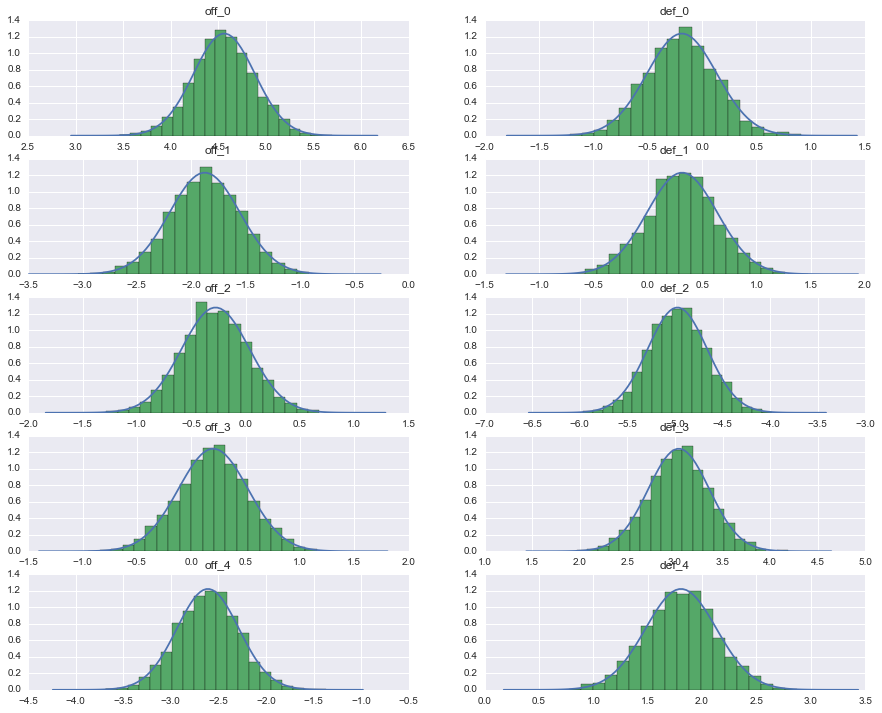

In [398]:
fig, axs = plt.subplots(5, 2, figsize=(15, 12))
for i in range(axs.shape[0]):
    x, density = helper.get_gaussian(sm_params['coefs']['off'][i], sm_params['stds']['off'][i])
    axs[i, 0].plot(x, density)
    axs[i, 0].hist(traces['off_centered'][:, i], normed=True, bins=20)
    axs[i, 0].set_title("off_%s" % i)
    x, density = helper.get_gaussian(sm_params['coefs']['def'][i], sm_params['stds']['def'][i])
    axs[i, 1].plot(x, density)
    axs[i, 1].hist(traces['def_centered'][:, i], normed=True, bins=20)
    axs[i, 1].set_title("def_%s" % i)

Ah, warm fuzzies. The Bayesian model matches the GLM, and we cry tears of unadultered joy at the purity of our universe. Anyway, let's plug on and check the intercept and home court advantage as well.

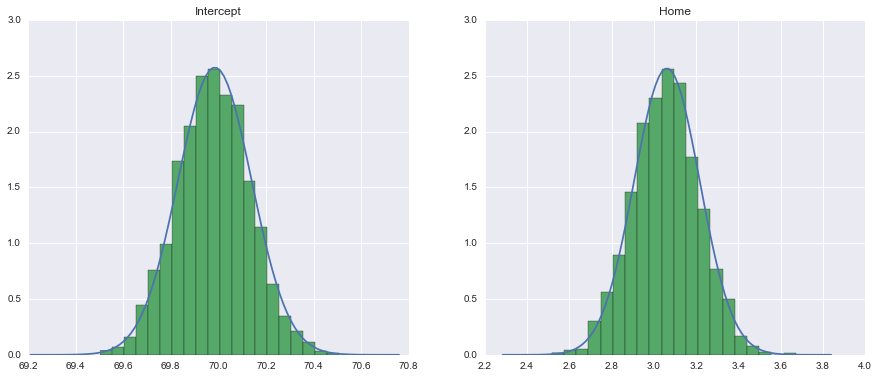

In [399]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x, density = helper.get_gaussian(sm_params['coefs']['intercept'], sm_params['stds']['intercept'])
axs[0].plot(x, density)
axs[0].hist(traces['intercept'], normed=True, bins=20)
axs[0].set_title("Intercept")
x, density = helper.get_gaussian(sm_params['coefs']['home'], sm_params['stds']['home'])
axs[1].plot(x, density)
axs[1].hist(traces['home'], normed=True, bins=20)
_ = axs[1].set_title("Home")

We nailed it! At this point, we're feeling pretty good. We came up with a nice model for rating sports teams, implemented it in two separate ways that ought to provide equivalent results, and we validated those results against each other and the true, known values that we made up. I highly suggest starting any analysis, especially with probabilistic models, by generating synthetic data and validating that the results are as expected against known parameters. One point of caution, however, is that you should _not_ expect, in general, to recover 100% of the true, known parameters inside of Bayesian credible intervals. Remember, these are 95% credible intervals such that if you have 100 parameters, you should expect that ~5 of those credible regions will not contain the true value.

Well, we've done our due diligence and we've thoroughly checked our models for completeness. I think we're finally ready to move on to using some real college basketball data in our analysis. First we'll rate. Then, we'll profit. I think.

## Rating real college basketball teams in 2016

Ideally, I'd like to provide a way to get the data I've collected for anyone to use, but I don't have an easy solution in mind at the moment. For now, I'll load data from a local PostgreSQL database which contains box score information for recent seasons of college basketball. I'll also use a helper function from a utility class that will return the data in the format that we need. Additionally, I'll load in Ken Pomeroy's publicly available ratings for the 2016 season so that we have something to compare to. In general, we should not assume that these ratings will be better than the model we've come up with, but given that Kenpom's ratings are the result of years of work, we should probably suspect they are better than this simple model we'll use here.

In [401]:
# get the data we need from the database
year = 2016
all_teams = pd.read_sql("SELECT ncaa, ncaaid, kenpom, conf FROM teams", DB.conn)
games_df, stacked_games_df, teams = util.get_data(year)
teams['i_team'] = np.arange(teams.shape[0])
games_df = games_df.sort('dt').reset_index().drop('index', 1)  # sort by date ascending
stacked_games_df = stacked_games_df.sort('dt').reset_index().drop('index', 1)
kenpom = pd.read_sql("SELECT team, adjo, adjd FROM kenpom_ranks WHERE year = %s" % year, DB.conn)
teams = teams.merge(all_teams, left_on='team_id', right_on='ncaaid')
teams = teams.merge(kenpom, how='left', left_on='kenpom', right_on='team').drop(['team', 'kenpom', 'ncaaid'], 1)
num_teams = teams.shape[0]
print("Got data for %s games and %s teams, between %s and %s" % (games_df.shape[0], num_teams,
                                                   games_df['dt'].min(), games_df['dt'].max()))

Got data for 5455 games and 351 teams, between 2015-11-13 and 2016-04-04


Also note that instead of using actual point scores as our rating metric, we'll use _points per possession_ (ppp) instead. You can read more on this topic [here](https://en.wikipedia.org/wiki/APBRmetrics), but basically ppp is a metric that normalizes a team's score by the number of opportunities it actually had to score, which is a more apt representation of their skill.

Let's inspect the games dataframe.

In [402]:
games_df.head()

,game_id,dt,hteam,hteam_id,ateam,ateam_id,hpts,hposs,apts,aposs,i_hteam,i_ateam,hppp,appp,neutral,home_outcome,poss,season
0,3948876,2015-11-13,Louisville,367.0,Samford,625.0,86.0,74.775,45.0,75.450,139,245,1.150117,0.596421,False,True,75.1125,2016
1,3951809,2015-11-13,George Mason,248.0,Colgate,153.0,53.0,67.625,66.0,65.350,93,57,0.783734,1.009946,False,False,66.4875,2016
2,3951861,2015-11-13,Hawaii,277.0,Montana St.,440.0,87.0,72.350,76.0,73.350,105,167,1.202488,1.036128,False,True,72.8500,2016
3,3949125,2015-11-13,Mississippi St.,430.0,Eastern Wash.,207.0,106.0,78.400,88.0,77.450,162,82,1.352041,1.136217,False,True,77.9250,2016
4,3951908,2015-11-13,Northern Ill.,503.0,Cal St. Northridge,101.0,83.0,71.150,71.0,70.725,200,38,1.166550,1.003888,False,True,70.9375,2016


Some important columns:

* `i_hteam`, `i_ateam` - a unique index for home and away teams, ranging from 0 to num_teams - 1
* `hppp`, `appp` - home and away points per possessions for each game. Computed according to the description [here](http://kenpom.com/blog/index.php/weblog/entry/stats_explained).
* `neutral` - boolean indicating whether or not game was played on a neutral court (this will be useful in assigning home court advantage)
* `hteam_id`, `ateam_id` - home and away team ids (these correspond to ids used on the website from which the data is collected)

Below, we perform similar data wrangling as before so that we can get the data in the form we need for both the linear model and the Bayesian model.

In [403]:
def get_home(neutral, teamid, homeid):
    if neutral:
        return 0
    elif teamid == homeid:
        return 1
    else:
        return -1
stacked_games_df['home'] = stacked_games_df.apply(lambda row: get_home(row.neutral, row.team_id, row.hteam_id), 1)
feature_df = stacked_games_df[['dt', 'i_team', 'i_opp', 'home', 'ppp']]
off_dummies = pd.get_dummies(feature_df['i_team'].astype(int), prefix='off')
def_dummies = pd.get_dummies(feature_df['i_opp'].astype(int), prefix='def')
glm_df = pd.concat([feature_df, helper.constrained_dummies(off_dummies), 
                    helper.constrained_dummies(def_dummies)], 1)
glm_df['const'] = 1

In [308]:
feature_df.head()

,dt,i_team,i_opp,home,ppp
0,2015-11-13,245,139.0,-1,0.596421
1,2015-11-13,230,41.0,-1,0.897170
2,2015-11-13,94,131.0,1,1.180556
3,2015-11-13,286,346.0,1,1.075044
4,2015-11-13,346,286.0,-1,1.035461


In [309]:
glm_df.head()

,dt,i_team,i_opp,home,ppp,off_0,off_1,off_2,off_3,off_4,...,def_341,def_342,def_343,def_344,def_345,def_346,def_347,def_348,def_349,const
0,2015-11-13,245,139.0,-1,0.596421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2015-11-13,230,41.0,-1,0.897170,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2015-11-13,94,131.0,1,1.180556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2015-11-13,286,346.0,1,1.075044,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,2015-11-13,346,286.0,-1,1.035461,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


With our data prepared in nice formats for both models (GLM and Bayesian), we can now train each model on the data.

In [310]:
feature_columns = ['off_%s' % i for i in range(num_teams - 1)] + ['def_%s' % i for i in range(num_teams - 1)] + \
['home'] + ['const']
X = glm_df[feature_columns].values
y = glm_df['ppp'].values
res = sm.GLM(y, X).fit()
sm_params = helper.extract_coefs(res, num_teams)

# add MLE ratings to the team's dataframe
teams['ortg_MLE'] = teams['i_team'].map(lambda i: sm_params['coefs']['off'][i])
teams['drtg_MLE'] = teams['i_team'].map(lambda i: sm_params['coefs']['def'][i])

In [311]:
with pm.Model() as real_model:
    off_coefs = pm.Normal('off_coefs', 0, sd=10, shape=num_teams)
    def_coefs = pm.Normal('def_coefs', 0, sd=10, shape=num_teams)
    off_centered = pm.Deterministic('off_centered', off_coefs - T.mean(off_coefs))
    def_centered = pm.Deterministic('def_centered', def_coefs - T.mean(def_coefs))
    
    std = pm.Uniform('std', 0.01, 5)
    
    home = pm.Normal('home', 0, sd=1)
    intercept = pm.Normal('intercept', np.mean(feature_df['ppp']), sd=2)
    
    mus = off_centered[feature_df['i_team'].astype(int).values] + \
        def_centered[feature_df['i_opp'].values.astype(int)] + intercept + home * feature_df['home'].values
    target = pm.Normal('target', mu=mus, sd=std, observed=feature_df['ppp'].values)
    
    MAP_estimate = pm.find_MAP()
    step = pm.NUTS([off_coefs, def_coefs, std, intercept, off_centered, def_centered, home])
    traces = pm.sample(3000, step=step, start=MAP_estimate, progressbar=True)

Applied interval-transform to std and added transformed std_interval to model.
 [-----------------100%-----------------] 3000 of 3000 complete in 49.8 sec

In [313]:
# add bayesian ratings to teams dataframe
off_mean = np.mean(MAP_estimate['off_coefs'])
def_mean = np.mean(MAP_estimate['def_coefs'])
teams['ortg_bayes'] = teams['i_team'].map(lambda i: MAP_estimate['off_coefs'][i] - off_mean)
teams['drtg_bayes'] = teams['i_team'].map(lambda i: MAP_estimate['def_coefs'][i] - def_mean)

With both models trained, let's check the GLM sampling distributions versus the Bayesian posterior densities as we did with synthesized data. 

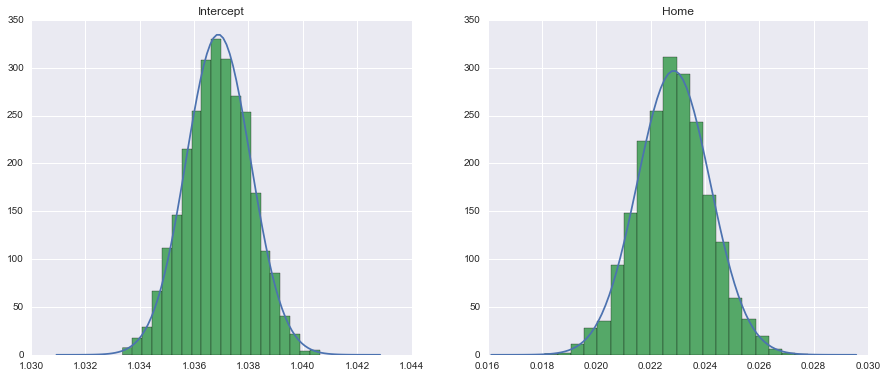

In [314]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x, density = helper.get_gaussian(sm_params['coefs']['intercept'], sm_params['stds']['intercept'])
axs[0].plot(x, density)
axs[0].hist(traces['intercept'], normed=True, bins=20)
axs[0].set_title("Intercept")
x, density = helper.get_gaussian(sm_params['coefs']['home'], sm_params['stds']['home'])
axs[1].plot(x, density)
axs[1].hist(traces['home'], normed=True, bins=20)
_ = axs[1].set_title("Home")

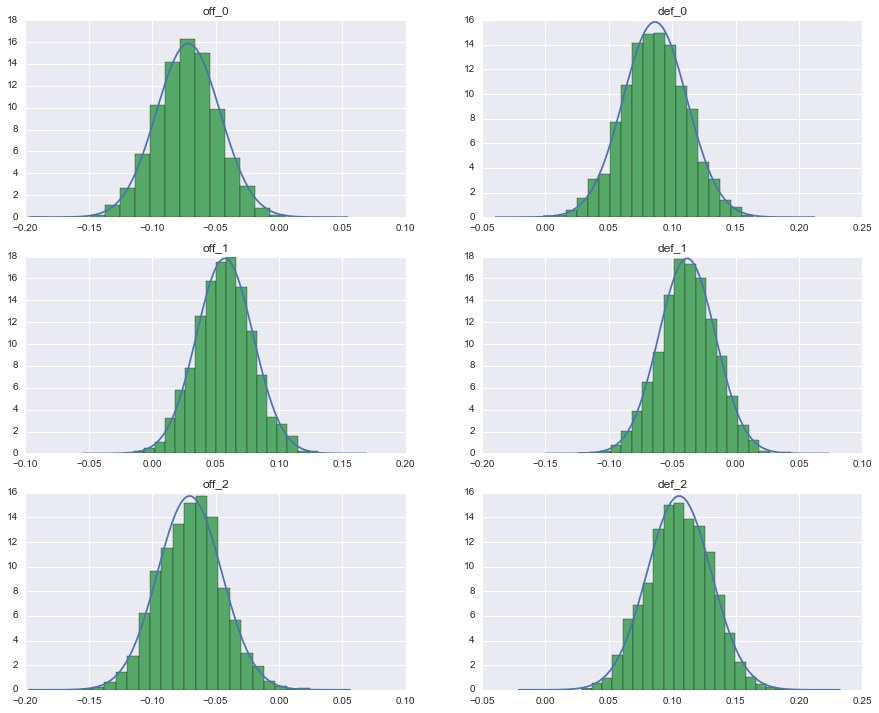

In [315]:
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
for i in range(axs.shape[0]):
    x, density = helper.get_gaussian(sm_params['coefs']['off'][i], sm_params['stds']['off'][i])
    axs[i, 0].plot(x, density)
    axs[i, 0].hist(traces['off_centered'][:, i], normed=True, bins=20)
    axs[i, 0].set_title("off_%s" % i)
    x, density = helper.get_gaussian(sm_params['coefs']['def'][i], sm_params['stds']['def'][i])
    axs[i, 1].plot(x, density)
    axs[i, 1].hist(traces['def_centered'][:, i], normed=True, bins=20)
    axs[i, 1].set_title("def_%s" % i)

Once again, the Bayesian posteriors are in agreement with the sampling distributions from the GLM, this time with a vastly increased number of parameters. Still, just because these two models agree with one another does not mean that they are correct. Before, we had true values to compare to because we generated the data ourselves, but this time we don't know the actual ratings (that's the entire point). Instead, we can compare to Ken Pomeroy's ratings - while these are not "true" values, they are a pretty good time-tested set of ratings to compare with.

### Kenpom rankings validation
As a final inspection in this exercise, we will check that our ranking of each of the team's aligns with the Kenpom rankings. However, since we should not expect these to match up perfectly, it will help to compare against a baseline model. For now, we can just check that our rankings are better than simply ranking teams on their raw average output in each game. First, let's compute each team's raw average.

In [404]:
teams['avg_ortg'] = stacked_games_df.groupby('i_team').mean()['ppp'].values
teams['avg_drtg'] = stacked_games_df.groupby('i_opp').mean()['ppp'].values

It turns out that Kenpom's ratings do not contain one of our team's, Texas Pan American, and since we are comparing _rankings_ we'll just drop it from our dataframe.

In [352]:
ranks = teams.dropna().rank(method='first', numeric_only=True, ascending=False)
cols = {'off_kp_avg': ranks['adjo'] - ranks['avg_ortg'],
        'def_kp_avg': ranks['adjd'] - ranks['avg_drtg'],
        'off_kp_GLM': ranks['adjo'] - ranks['ortg_MLE'],
        'def_kp_GLM': ranks['adjd'] - ranks['drtg_MLE'],
        'off_kp_bayes': ranks['adjo'] - ranks['ortg_bayes'],
        'def_kp_bayes': ranks['adjd'] - ranks['drtg_bayes']}
rank_dists = pd.DataFrame(cols)
rank_dists.describe()

,def_kp_GLM,def_kp_avg,def_kp_bayes,off_kp_GLM,off_kp_avg,off_kp_bayes
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,20.843392,47.601678,20.843392,18.865836,35.988616,18.865836
min,-53.000000,-119.000000,-53.000000,-48.000000,-98.000000,-48.000000
25%,-13.000000,-30.000000,-13.000000,-11.750000,-20.000000,-11.750000
50%,0.000000,-1.500000,0.000000,0.000000,1.500000,0.000000
75%,11.000000,28.750000,11.000000,10.000000,23.000000,10.000000
max,79.000000,160.000000,79.000000,85.000000,97.000000,85.000000


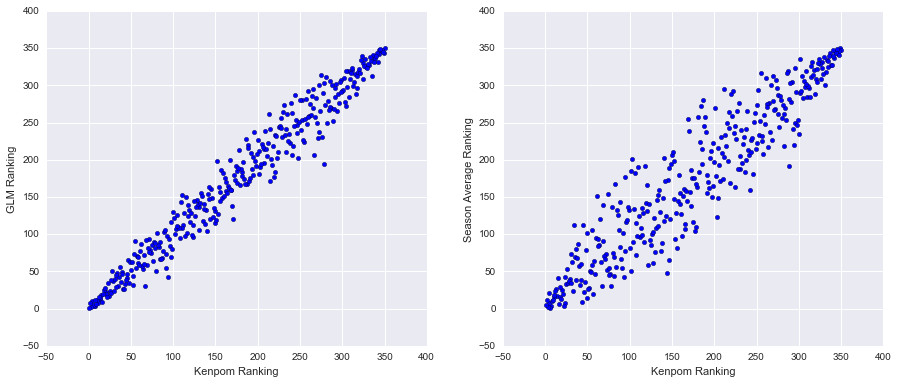

In [414]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(ranks['adjo'], ranks['ortg_MLE'])
axs[0].set_xlabel("Kenpom Ranking")
axs[0].set_ylabel("GLM Ranking")
axs[1].scatter(ranks['adjo'], ranks['avg_ortg'])
axs[1].set_xlabel("Kenpom Ranking")
axs[1].set_ylabel("Season Average Ranking")

First, take a look at the summary statistics of the ranking distances dataframe. The 25% and 75% quantiles are in the 20-30 ranking spots range for the average ratings to kenpom ratings, while our GLM and Bayesian ratings have improved these to the 10-15 range. Additionally, the standard deviations of the distances are greatly reduced. Finally, we can inspect the scatter plots above to see that our ratings are much more tightly coupled to the Kenpom ratings than are the raw averages. We could go further still, but this should be enough to convince ourselves that our ratings are significantly better than our average baseiline ratings.

On a related note, there are many reasons that our ratings will not exactly match Ken Pomeroy's. To be more specific, there are many reasons why his ratings are better than this first version. For one, he applies a temporal weighting on games that essentially phases out really old games that aren't likely to reflect a team's current skill as well as recent games. He also reduces the weight of enormous blowouts such that a team that beats an inferior opponent by 60 does not get (much) more credit than a team that beats an inferior opponent by 20. There are other good reasons as well (hey, the guy's been doing this a while), but with some time and experimentation, our rating system here may get better. This brings me to my next point: what does "better" mean?

Most likely, we are rating sports teams because we'd like to be able to intelligently predict the outcome of a matchup before it happens. We might care about predicting the actual score, or just predicting the winner, but either way we will evaluate our ratings on how well they predict future data. In this exercise, we rated each of the team's in Division 1 college basketball after all the games had been played... this doesn't sound very useful! In a follow up post, I'll take a look at generating rankings throughout the season and applying them for prediction of past "future" games.

## Conclusions

Saying that you used probabilistic programming to create a rating system for college basketball teams using a Bayesian network definitely _sounds_ cool. But as we saw, a linear regression gave us all we needed to create a solid, effective rating system. So why did we bother with the Bayesian network? For one, it was a nice way to learn PyMC and probabilistic programming. Second, the Bayesian network will give us nice flexibility to extend our model in the future, and to also address some problems we haven't discussed. How should we rate teams in the beginning of the season when there is really very little data to work with? The Bayesian model will allow us to specify priors on the team ratings, which we could base off of a variety of things, the simplest being the previous year's ratings. Bayes nets also allow us to reason about the uncertainty in our ratings more clearly. We should be clear not to confuse the sampling distributions of the coefficients provided by the GLM with the posterior distribution on the parameters we get from the Bayesian model. Among other things, the Bayes net gives us the ability to say things like "team A's rating is between 0.9 and 1.1 with 95% probability," something we cannot say using frequentist methods.